# Map Transformations Scratch
Default form of coordinates is cartesian on unit sphere. Units in/out of non-plotting functions is radians. Degrees for plotting functions.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

DEG2RAD = np.pi / 180
RAD2DEG = 180 / np.pi
M2KM = 1000
RE = 6378 * M2KM

In [28]:
fname = "./data/vector/custom_coastline.npy"
coords_load = np.load(fname) # input coords are spherical, degrees

<IPython.core.display.Javascript object>


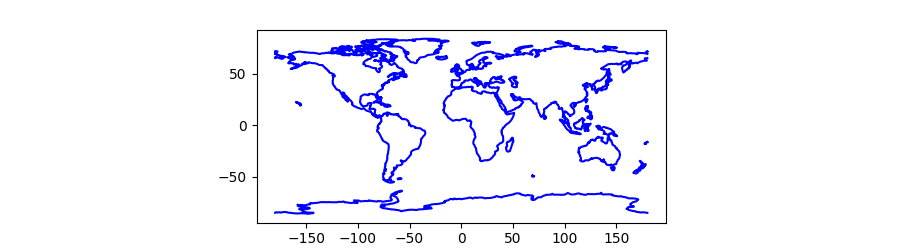

In [29]:
fig = plt.figure(figsize=(9,2.5))
ax = fig.add_subplot(111)

ax.plot(coords_load[:,0],coords_load[:,1],"b")
ax.set_aspect("equal")
plt.show()

## Utilities

In [55]:
def calc_line_breaks(points, dmax=0.5):
    # where the line rolls over the break in x coord or y coord
    points2 = np.roll(points, 1, 0)
    points2[0, :] = points[0,:]
    d = np.abs(points2 - points)
    
    return np.argwhere(np.logical_or(d[:,0] > dmax, d[:,1] > dmax)).reshape(-1)

def plot_line_map(points, breaks=None, ax=None, figsize=None, tickdata=None, color="k", linewidth=1):
    if ax is None:
        if figsize is not None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
        else:
            _, ax = plt.subplots()
        ax.set_aspect("equal")
        
    if breaks is None:
        ax.plot(points[:,0], points[:,1], color=color, linewidth=linewidth)
    else:
        last_br = 0
        for br in breaks:
            ax.plot(points[last_br:br, 0], points[last_br:br, 1], color=color, linewidth=linewidth)
            last_br = br
            
        ax.plot(points[last_br:, 0], points[last_br:, 1], color=color, linewidth=linewidth)
        
    if tickdata is None:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
    return ax

def make_grid(parallels, meridians, numsteps=100):
    # inputs in radians, output is cartesian
    x_parallel = np.linspace(-np.pi, np.pi, numsteps)
    y_meridian = np.linspace(-np.pi/2, np.pi/2, numsteps)
    
    grid = np.zeros(shape=((numsteps + 1) * (len(parallels) + len(meridians)),2))
    
    i = 0
    
    for p in parallels:
        grid[i*(numsteps+1):(i+1)*(numsteps+1)-1,0] = x_parallel
        grid[i*(numsteps+1):(i+1)*(numsteps+1)-1,1] = p
        grid[(i+1)*(numsteps+1)-1,:] = np.nan
        i += 1
        
    for m in meridians:
        grid[i*(numsteps+1):(i+1)*(numsteps+1)-1,0] = m
        grid[i*(numsteps+1):(i+1)*(numsteps+1)-1,1] = y_meridian
        grid[(i+1)*(numsteps+1)-1,:] = np.nan
        i += 1
        
    return spherical_to_cartesian(grid)
        
    
def correct_ticks(ax, x_y, center, half_width=180, step=60):
    num_ticks = int(2 * half_width / step) + 1
    tick_locs = [-half_width + i*step for i in range(num_ticks)]
    tick_labels = [(val + half_width + center) % (2 * half_width) - half_width for val in tick_locs]
    
    if x_y == "x":
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)
    else:
        ax.set_yticks(tick_locs)
        ax.set_yticklabels(tick_labels)
        
    return ax
    
def rotmat_euler321(anga, angb, angc):
    # dcm that rotates from base to rotated frame, all in radians
    rota = np.array([[np.cos(anga),np.sin(anga),0],[-np.sin(anga),np.cos(anga),0],[0,0,1]])
    rotb = np.array([[np.cos(angb), 0, np.sin(angb)],[0,1,0],[-np.sin(angb), 0, np.cos(angb)]])
    rotc = np.array([[1, 0, 0], [0, np.cos(angc), -np.sin(angc)], [0, np.sin(angc), np.cos(angc)]])
    
    return np.dot(rotc, np.dot(rotb, rota))

def rotmat_euler323(anga, angb, angc):
    # dcm that rotates from base to rotated frame, all in radians
    rota = np.array([[np.cos(anga),np.sin(anga),0],[-np.sin(anga),np.cos(anga),0],[0,0,1]])
    rotb = np.array([[np.cos(angb), 0, np.sin(angb)],[0,1,0],[-np.sin(angb), 0, np.cos(angb)]])
    rotc = np.array([[np.cos(angc),np.sin(angc),0],[-np.sin(angc),np.cos(angc),0],[0,0,1]])
    
    return np.dot(rotc, np.dot(rotb, rota))

def spherical_to_cartesian(coords):
    coords2 = np.zeros(shape=(coords.shape[0],3))
    coords2[:,0] = np.cos(coords[:,1]) * np.cos(coords[:,0])
    coords2[:,1] = np.cos(coords[:,1]) * np.sin(coords[:,0])
    coords2[:,2] = np.sin(coords[:,1])
    return coords2

def cartesian_to_spherical(coords):
    coords2 = np.zeros(shape=(coords.shape[0],2))
    coords2[:,0] = np.arctan2(coords[:,1],coords[:,0])
    coords2[:,1] = np.arcsin(coords[:,2])
    return coords2

def transform_spherical(coords, center_lon=0, center_lat=0, heading=0):
    rotmat = rotmat_euler321(center_lon, center_lat, heading)
    coords2_cartesian = np.dot(coords, rotmat.transpose())
    return cartesian_to_spherical(coords2_cartesian)

def transform_mercator(coords, truncate_north, truncate_south=None, ref_lat=0,
                       axis_lon=0, axis_lat=np.pi/2, axis_roll=0,
                       return_ref_parallels=False):
    # all in radians
    # ref_lat is latitude where scale is equal to 1 (after axis rotation)
    # axis rotation happens 3-2-3
    coords_rotated = np.dot(coords, rotmat_euler323(axis_lon, axis_lat - np.pi/2, axis_roll).transpose())
    coords_spherical = cartesian_to_spherical(coords_rotated)
    
    # scale factor: 1 = K * sec(lat) --> K = cos(lat)
    K = np.cos(ref_lat)
    
    if truncate_south is None:
        truncate_south = -truncate_north
        
    coords_spherical[coords_spherical[:,1]>truncate_north, :] = np.nan
    coords_spherical[coords_spherical[:,1]<truncate_south, :] = np.nan
    
    coords_mercator = np.zeros(shape=coords_spherical.shape)
    coords_mercator[:,0] = K * coords_spherical[:,0]
    coords_mercator[:,1] = K * np.log(np.tan(np.pi/4 + coords_spherical[:,1]/2))
    
    if return_ref_parallels:
        ref_parallels = np.array([[-np.pi, ref_lat], [0, ref_lat], [np.pi, ref_lat],
                                  [np.nan, np.nan],
                                  [-np.pi, -ref_lat], [0, -ref_lat], [np.pi, -ref_lat]])
        
        ref_parallels[:,0] = K * ref_parallels[:,0]
        ref_parallels[:,1] = K * np.log(np.tan(np.pi/4 + ref_parallels[:,1]/2))
        
        return coords_mercator, ref_parallels
    
    else:
        return coords_mercator


def transform_lambert_cylindrical(coords, truncate_north, truncate_south=None, ref_lat=0,
                                  return_ref_parallels=False):
    # equal area cylindrical projection - lambert has ref lat at 0, gall-peters at 45
    # scale factor horz: k = K * sec(lat) 
    # scale factor vert: h = y'
    # equal area constraint: h = 1 / k --> y' = 1/K * cos(lat) --> y = 1/K * sin(lat)
    # ref_lat is where k = h = 1 (scaling is 1, no distortion)
    
    coords_spherical = cartesian_to_spherical(coords)
    
    # 1 = K * sec(ref_lat)
    K = np.cos(ref_lat)
    
    if truncate_south is None:
        truncate_south = -truncate_north
        
    coords_spherical[coords_spherical[:,1]>truncate_north, :] = np.nan
    coords_spherical[coords_spherical[:,1]<truncate_south, :] = np.nan
    
    coords_lambert = np.zeros(shape=coords_spherical.shape)
    coords_lambert[:,0] = K * coords_spherical[:,0]
    coords_lambert[:,1] = 1 / K * np.sin(coords_spherical[:,1])
    
    if return_ref_parallels:
        ref_parallels = np.array([[-np.pi, ref_lat], [0, ref_lat], [np.pi, ref_lat],
                                  [np.nan, np.nan],
                                  [-np.pi, -ref_lat], [0, -ref_lat], [np.pi, -ref_lat]])
        
        ref_parallels[:,0] = K * ref_parallels[:,0]
        ref_parallels[:,1] = 1 / K * np.sin(ref_parallels[:,1])
        
        return coords_lambert, ref_parallels
    
    else:
        return coords_lambert 

## Default Coords

In [31]:
coords = spherical_to_cartesian(coords_load * DEG2RAD)
grid = make_grid([-np.pi/2, -np.pi/3, -np.pi/6, 0, np.pi/6, np.pi/3, np.pi/2],
                           [-np.pi, -2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3, np.pi])

## Equirectangular

<IPython.core.display.Javascript object>


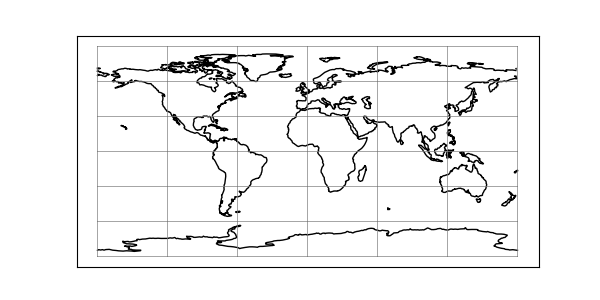

In [18]:
center_lon = 0*DEG2RAD
center_lat = 0*DEG2RAD
heading = 0*DEG2RAD

coords2 = transform_spherical(coords, center_lon, center_lat, heading)
grid2 = transform_spherical(grid, center_lon, center_lat, heading)
breaks = calc_line_breaks(coords2)
breaks_grid = calc_line_breaks(grid2)


ax = plot_line_map(coords2, breaks, figsize=(6,3))
ax = plot_line_map(grid2, breaks_grid, ax=ax, color="grey", linewidth=0.5)
# ax = correct_ticks(ax, "x", center_lon)

<IPython.core.display.Javascript object>


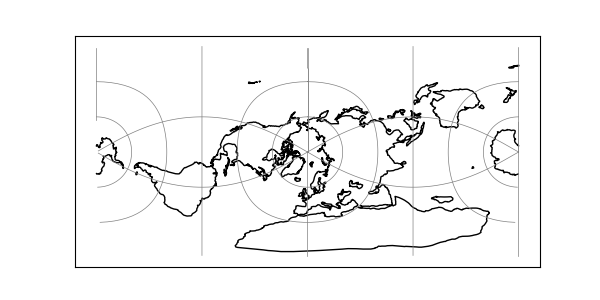

In [19]:
center_lon = 90*DEG2RAD
center_lat = 90*DEG2RAD
heading = 90*DEG2RAD

coords2 = transform_spherical(coords, center_lon, center_lat, heading)
grid2 = transform_spherical(grid, center_lon, center_lat, heading)
breaks = calc_line_breaks(coords2)
breaks_grid = calc_line_breaks(grid2)


ax = plot_line_map(coords2, breaks, figsize=(6,3))
ax = plot_line_map(grid2, breaks_grid, ax=ax, color="grey", linewidth=0.5)

## Central Cylindrical

<IPython.core.display.Javascript object>


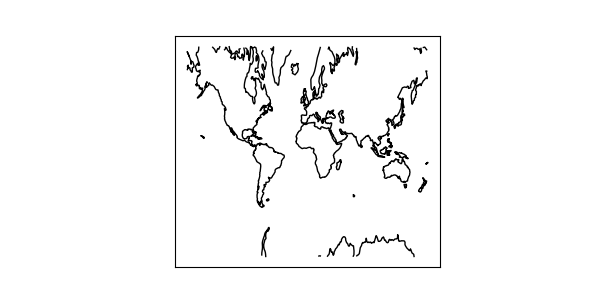

In [20]:
truncate_lat = 70 * DEG2RAD

coords_spherical = cartesian_to_spherical(coords)
coords_cylindrical = np.zeros(shape=coords_spherical.shape)
coords_cylindrical[:,0] = coords_spherical[:,0]
coords_cylindrical[:,1] = np.tan(coords_spherical[:,1])
coords_cylindrical[np.abs(coords_spherical[:,1])>truncate_lat,:] = np.nan


breaks = calc_line_breaks(coords_cylindrical, 1)
ax = plot_line_map(coords_cylindrical, breaks, figsize=(6,3))

## Mercator

<IPython.core.display.Javascript object>


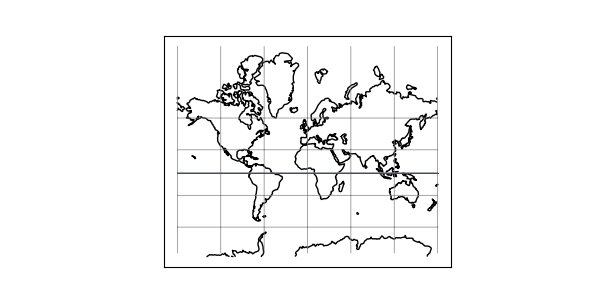

In [48]:
truncate_north = 85 * DEG2RAD
truncate_south = -75 * DEG2RAD

ref_lat = 0 * DEG2RAD

axis_lon = 0 * DEG2RAD
axis_lat = 90 * DEG2RAD
axis_roll = 0 * DEG2RAD

coords_mercator, ref_parallels = transform_mercator(coords, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll, True)
grid_mercator = transform_mercator(grid, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll)

breaks = calc_line_breaks(coords_mercator)
breaks_grid = calc_line_breaks(grid_mercator)

ax = plot_line_map(coords_mercator, breaks, figsize=(6,3))
ax = plot_line_map(grid_mercator, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

<IPython.core.display.Javascript object>


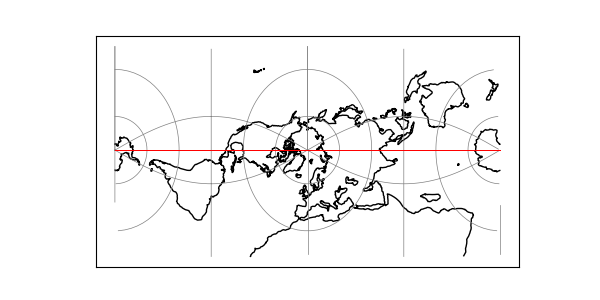

In [53]:
truncate_north = 70 * DEG2RAD
truncate_south = -70 * DEG2RAD

ref_lat = 0 * DEG2RAD

axis_lon = 180 * DEG2RAD
axis_lat = 0 * DEG2RAD
axis_roll = 180 * DEG2RAD

coords_mercator, ref_parallels = transform_mercator(coords, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll, True)
grid_mercator = transform_mercator(grid, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll)

breaks = calc_line_breaks(coords_mercator)
breaks_grid = calc_line_breaks(grid_mercator)

ax = plot_line_map(coords_mercator, breaks, figsize=(6,3))
ax = plot_line_map(grid_mercator, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

Two lat/lon points define oblique mercator axis

<IPython.core.display.Javascript object>


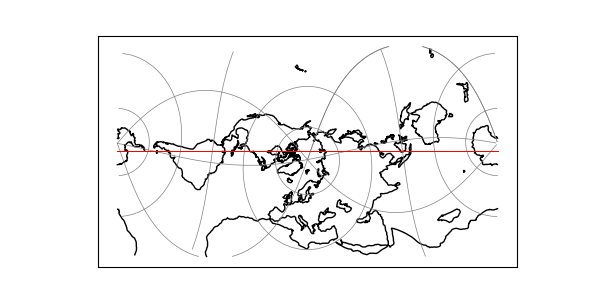

In [52]:
lat1 = 40*DEG2RAD
lon1 = -77*DEG2RAD

lat2 = 40 * DEG2RAD
lon2 = 116*DEG2RAD

axis_roll = 180 * DEG2RAD

truncate_north = 70 * DEG2RAD
truncate_south = -70 * DEG2RAD

ref_lat = 0 * DEG2RAD

r1 = np.array([np.cos(lat1)*np.cos(lon1), np.cos(lat1)*np.sin(lon1), np.sin(lat1)])
r2 = np.array([np.cos(lat2)*np.cos(lon2), np.cos(lat2)*np.sin(lon2), np.sin(lat2)])

axrot = np.cross(r1, r2)
axrot = axrot / np.linalg.norm(axrot)

axis_lat = np.arcsin(axrot[2])
axis_lon = np.arctan2(axrot[1], axrot[0])

coords_mercator, ref_parallels = transform_mercator(coords, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll, True)
grid_mercator = transform_mercator(grid, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll)

breaks = calc_line_breaks(coords_mercator)
breaks_grid = calc_line_breaks(grid_mercator)

ax = plot_line_map(coords_mercator, breaks, figsize=(6,3))
ax = plot_line_map(grid_mercator, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

## Lambert Equal Area

<IPython.core.display.Javascript object>


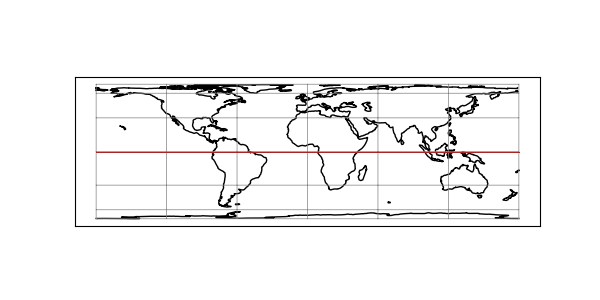

In [59]:
truncate_north = 90 * DEG2RAD
truncate_south = -90 * DEG2RAD

ref_lat = 0

coords_lambert, ref_parallels = transform_lambert_cylindrical(coords, truncate_north, truncate_south, ref_lat, True)
grid_lambert = transform_lambert_cylindrical(grid, truncate_north, truncate_south, ref_lat)

breaks = calc_line_breaks(coords_lambert)
breaks_grid = calc_line_breaks(grid_lambert)

ax = plot_line_map(coords_lambert, breaks, figsize=(6,3))
ax = plot_line_map(grid_lambert, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

## Gall-Peters

<IPython.core.display.Javascript object>


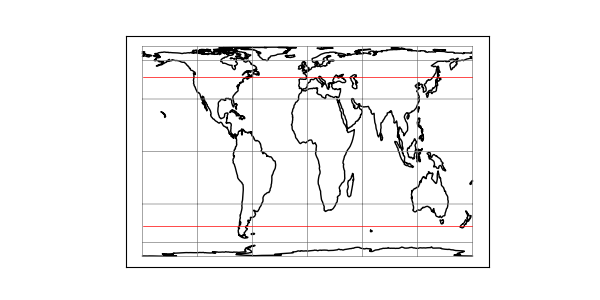

In [58]:
truncate_north = 90 * DEG2RAD
truncate_south = -90 * DEG2RAD

ref_lat = 45 * DEG2RAD

coords_lambert, ref_parallels = transform_lambert_cylindrical(coords, truncate_north, truncate_south, ref_lat, True)
grid_lambert = transform_lambert_cylindrical(grid, truncate_north, truncate_south, ref_lat)

breaks = calc_line_breaks(coords_lambert)
breaks_grid = calc_line_breaks(grid_lambert)

ax = plot_line_map(coords_lambert, breaks, figsize=(6,3))
ax = plot_line_map(grid_lambert, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

## Sinusoidal

In [60]:
def transform_sinusoidal(coords, center_lon=0, center_lat=0, heading=0):
    # axis rotation happens 3-2-1
    coords_spherical = transform_spherical(coords, center_lon, center_lat, heading)
    
    coords_sin = np.zeros(shape=coords_spherical.shape)
    coords_sin[:,0] = coords_spherical[:,0] * np.cos(coords_spherical[:,1])
    coords_sin[:,1] = coords_spherical[:,1]
    
    return coords_sin

<IPython.core.display.Javascript object>


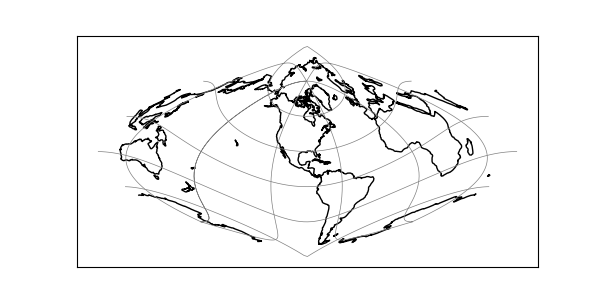

In [66]:
center_lon = -90*DEG2RAD
center_lat = 30*DEG2RAD
heading = 0*DEG2RAD

coords_sin = transform_sinusoidal(coords, center_lon, center_lat, heading)
grid_sin = transform_sinusoidal(grid, center_lon, center_lat, heading)

breaks = calc_line_breaks(coords_sin)
breaks_grid = calc_line_breaks(grid_sin)

ax = plot_line_map(coords_sin, breaks, figsize=(6,3))
ax = plot_line_map(grid_sin, breaks_grid, ax=ax, color="grey", linewidth=0.5)

## Altitude Perspective
Heading is deg ccw from North (assume North is towards -180 lon for 90/-90 lat)

<IPython.core.display.Javascript object>


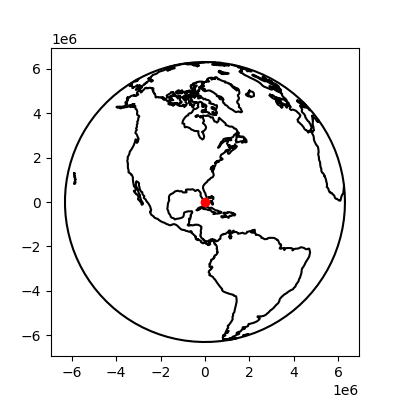

In [24]:
alt = 36000*M2KM
sub_lon = -81
sub_lat = 25
heading = 0

r_norm = np.array([np.cos(sub_lon*DEG2RAD)*np.cos(sub_lat*DEG2RAD),
                   np.sin(sub_lon*DEG2RAD)*np.cos(sub_lat*DEG2RAD),
                   np.sin(sub_lat*DEG2RAD)])

r = (alt + RE) * r_norm

# build frame with r as aligned, north as constrained
p1 = r_norm

if p1[0] == 0 and p1[1] == 0:
    p2 = np.array([0, -1, 0])
else:
    p2 = np.array([1, 0, 0])
    
p2 = p2 - np.dot(p1, p2) * p1
p2 = p2 / np.linalg.norm(p2)

p3 = np.cross(p1, p2)

rotmat_ecef_to_p = np.stack([p1, p2, p3])

# put all points in p frame, relative to r
coords_p = np.dot(rotmat_ecef_to_p, (coords*RE - r.reshape(1,3)).transpose()).transpose()

# use only the second and third coordinates for projection
coords_p_proj = coords_p[:,1:]

# don't plot anything that is further away than earth limb
limbdist = np.sqrt((alt+RE)**2 - RE**2)
coords_p_dist = np.linalg.norm(coords_p, axis=1)
coords_p_proj[coords_p_dist > limbdist,:] = np.nan

# plot the limb
limbplot = RE / (alt+RE) * limbdist
t = np.linspace(0,2*np.pi,100)
limbx = limbplot*np.cos(t)
limby = limbplot*np.sin(t)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(coords_p_proj[:,0],coords_p_proj[:,1],"k")
ax.plot(limbx,limby,"k")
ax.plot(0,0,"ro")
ax.set_aspect("equal")
plt.show()